# Hypothesis Testing in Python

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin  # provides different methods for hypothesis testing

# change the default console output settings in NumPy and pandas to improve readability
pd.options.display.max_columns = 20
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 80
np.set_printoptions(precision=4, suppress=True)

# Import datasets (pyarrow is required to work with the feather format)
stack_overflow = pd.read_feather("datasets/stack_overflow.feather")

late_shipments = pd.read_feather("datasets/late_shipments.feather")

sample_dem_data = pd.read_feather("datasets/dem_votes_potus_12_16.feather")

## 1. Hypothesis Testing Fundamentals

### Hypothesis Testing Fundamentals

**Hypothesis testing** is a statistical method used to make decisions or inferences about a population based   
on a sample. It helps to determine whether the observed data provides enough evidence to reject a specific   
assumption (the **null hypothesis**, $H_{0}$) in favor of an alternative hypothesis ($H_{1}$).

### How Hypothesis Testing Works

1. **Formulate Hypotheses**: Define the null hypothesis ($H_{0}$), which typically represents the default   
assumption (e.g., no effect or no difference), and the alternative hypothesis ($H_{1}$), which represents   
what you aim to prove.

2. **Collect Data**: Gather data from a sample to test the hypotheses.

3. **Select a Test Statistic**: Choose a test statistic (e.g., z-score) to quantify the difference between   
the sample data and what the null hypothesis predicts.

4. **Compute the P-value**: The **p-value** represents the probability of obtaining a result as extreme as   
or more extreme than the observed data if the null hypothesis is true. A small p-value (typically < 0.05)   
suggests evidence against $H_{0}$.

5. **Make a Decision**: Compare the p-value to a pre-determined significance level ($\alpha$).   
If $p-value$ < $\alpha$, reject $H_{0}$ in favor of $H_{1}$.

6. **Conclusion**: Interpret the result in the context of the problem.

### Common Concepts

- **Z-scores**: Measure how far a data point is from the mean in terms of standard deviations.
- **P-values**: Represent the probability of observing data at least as extreme as the sample,   
assuming $H_{0}$ is true.
- **Errors**: 
  - **False positive (Type I error)**: Rejecting $H_{0}$ when it is actually true.
  - **False negative (Type II error)**: Failing to reject $H_{0}$ when $H_{1}$ is true.

### Applications

Hypothesis testing helps solve problems like determining whether a new treatment is effective, whether   
a manufacturing process meets quality standards, or whether a coin is biased.

In a **one-sample proportion test**, you could test whether the proportion of successes in a sample differs   
from a known or hypothesized population proportion (e.g., determining if a new drug's success rate differs   
from the standard rate).

<small>_Source: OpenAI, ChatGPT_</small>

### 1.1 Hypothesis tests and z-scores

The `late_shipments` dataset contains supply chain data on the delivery of medical supplies. Each row   
represents one delivery of a part. The `late` columns denotes whether or not the part was delivered late.   
A value of `"Yes"` means that the part was delivered late, and a value of `"No"` means the part was delivered   
on time.

In [3]:
late_shipments.head()

,id,country,managed_by,fulfill_via,vendor_inco_term,shipment_mode,late_delivery,late,product_group,sub_classification,...,line_item_quantity,line_item_value,pack_price,unit_price,manufacturing_site,first_line_designation,weight_kilograms,freight_cost_usd,freight_cost_groups,line_item_insurance_usd
0,36203.0,Nigeria,PMO - US,Direct Drop,EXW,Air,1.0,Yes,HRDT,HIV test,...,2996.0,266644.00,89.00,0.89,"Alere Medical Co., Ltd.",Yes,1426.0,33279.83,expensive,373.83
1,30998.0,Botswana,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test,...,25.0,800.00,32.00,1.60,"Trinity Biotech, Plc",Yes,10.0,559.89,reasonable,1.72
2,69871.0,Vietnam,PMO - US,Direct Drop,EXW,Air,0.0,No,ARV,Adult,...,22925.0,110040.00,4.80,0.08,Hetero Unit III Hyderabad IN,Yes,3723.0,19056.13,expensive,181.57
3,17648.0,South Africa,PMO - US,Direct Drop,DDP,Ocean,0.0,No,ARV,Adult,...,152535.0,361507.95,2.37,0.04,"Aurobindo Unit III, India",Yes,7698.0,11372.23,expensive,779.41
4,5647.0,Uganda,PMO - US,Direct Drop,EXW,Air,0.0,No,HRDT,HIV test - Ancillary,...,850.0,8.50,0.01,0.00,Inverness Japan,Yes,56.0,360.00,reasonable,0.01


#### _Calculating the sample mean_

In [4]:
# Calculate the proportion of late shipments
late_prop_samp = (late_shipments["late"] == "Yes").mean()

print(late_prop_samp)

0.061


The proportion of late shipments in the sample is 6.1%.

#### _Calculating a z-score_


Since variables have arbitrary ranges and units, we need to standardize them. For example, a hypothesis   

test that gave different answers if the variables were in Euros instead of US dollars would be of little   

value. Standardization avoids that. 

One standardized value of interest in a hypothesis test is called a z-score.

In [5]:
# Hypothesize that the proportion of late shipments is 6%
late_prop_hyp = 0.06

In [6]:
# Create a bootstrap distribution of the proportion of late shipments, as a list
late_shipments_bootstrap_dist = []

for i in range(5000):
    late_shipments_bootstrap_dist.append(
        np.mean(
            late_shipments.sample(frac=1, replace=True)["late"] == "Yes"
        )
    )

late_shipments_bootstrap_dist[0:5]

[0.058, 0.064, 0.061, 0.045, 0.061]

In [7]:
# Calculate the standard error from the standard deviation of the bootstrap distribution
std_error = np.std(late_shipments_bootstrap_dist, ddof=1)

In [8]:
# Calculate the z-score of late_prop_samp
z_score = (late_prop_samp - late_prop_hyp) / std_error 

print(z_score)

0.13077914743852603


The `z-score` is a standardized measure of the difference between   
the sample statistic and the hypothesized statistic.

### 1.2 p-values

#### _Left-tail, right tail, two tails_

Hypothesis tests are used to determine whether the sample statistic lies in the tails of the null   
distribution. However, the way that the alternative hypothesis is phrased affects which tail(s) we are   
interested in.

| **Two tails**                                                                                                   | **Left tail**                                                                                               | **Right tail**                                                 |
|-----------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------|
| Is there a difference beween the <br>voting preferences of 40-year-olds<br>and 80-year-olds?                    | Are grapes lower in popularity than<br>raisins on average?                                                  | Do hamburgers have more calories<br>than hot dogs, on average? |
| Should we expect Slack and Zoom <br>to have dissimilar mean numbers of <br>employees over the last three years? | Is there evidence to conclude that <br>Belgian workers tend to have lower<br>salaries than Italian workers? | Do cats tend to live longer than<br>dogs?                      |

The tails of the distribution that are relevant depend on whether the alternative hypothesis refers to  
"greater than", "less than", or "differences between."

#### _Calculating p-values_

In order to determine whether to choose the null hypothesis, or the alternative hypothesis, calculate a  
p-value from the z-score.

The null hypothesis, $H_{0}$, is that the proportion of late shipments is six percent.

The alternative hypothesis, $H_{1}$, is that the proportion of late shipments is  
`greater than` six percent.

**Question**  
What type of test should be used for this alternative hypothesis?

**Answer**  
Right-tailed

The p-value is calculated by transforming the z-score   
with the standard normal cumulative distribution function.

In [9]:
# Calculate the z-score of late_prop_samp
z_score = (late_prop_samp - late_prop_hyp) / std_error

# Calculate the p-value
from scipy.stats import norm

p_value = 1 - norm.cdf(z_score, loc=0, scale=1)

print(p_value)

0.4479750096183722


### 1.3 Statistical significance

#### _Decisions from p-values_

The p-value, $p$, is a measure of the amount of evidence to reject the null hypothesis or not.  

A decision about which hypothesis to support, can be made by comparing the p-value to the  
significance level, $\alpha$.

**Question**  
What is the correct conclusion from the decision rule for a significance level, $\alpha$?

**Answer**  
If $p \le \alpha$, reject $H_{0}$

#### _Calculating a confidence interval_

A confidence interval provides a range of values, within which the true population parameter is likely to  
fall. Instead of giving a single estimate, it accounts for sampling variability.  

For example, if the hypothesized proportion of late shipments is 6%, the actual proportion in any sample  
may differ slightly.  

A **confidence interval** expresses this uncertainty by stating, "We are 95% confident that the true  
proportion of late shipments lies between A and B." The interval gives a more accurate representation than  
a single point estimate.

In [10]:
''' Calculate a 95% confidence interval from 'late_shipments_boot_distn' using the 
quantile method. '''

lower = np.quantile(late_shipments_bootstrap_dist, 0.025)

upper = np.quantile(late_shipments_bootstrap_dist, 0.975)

print(lower, upper)

0.046 0.076


**Question**  
Does the confidence interval support the decision to keep the original assumption  
that 6% is a reasonable estimate for the population value?

**Answer**  
Yes, since 0.06 is included in the 95% confidence interval and we failed to  
reject $H_{0}$ due to a large p-value, the results are similar.

In other words, when you have a confidence interval width equal to one minus  
the significance level, if the hypothesized population parameter is within the  
confidence interval, you should fail to reject the null hypothesis.

#### _Type I and type II errors_

In hypothesis testing, there are two possible correct outcomes and two types of errors:

- A **false positive** (Type I error) occurs when you reject the null hypothesis when it's actually true.

- A **false negative** (Type II error) happens when you fail to reject the null hypothesis when it's  
actually false.

## 2. Two-Sample and ANOVA Tests

Statistical methods for comparing the means of different groups to determine  
if they are significantly different from each other:

1. **T-tests for Two Groups**: 
   - A t-test is used to compare the means of two groups to check if the difference between them is  
   statistically significant. It helps determine whether any observed difference in sample means reflects  
   a real difference in the population or is due to random chance. You’ll typically use either an independent  
   t-test (for two separate groups) or a paired t-test (for related or matched samples).

2. **ANOVA (Analysis of Variance) for More Than Two Groups**: 
   - When comparing means across more than two groups, using multiple t-tests increases the risk of a  
   Type I error (false positive). ANOVA solves this by testing the overall variance among the group means  
   in one test. If ANOVA finds significant differences, it indicates that at least one group mean is  
   different, but it doesn’t specify which groups differ.

3. **Pairwise t-tests After ANOVA**:
   - If ANOVA shows significant differences, you can use pairwise t-tests (also called post-hoc tests) to  
   compare the means of each pair of groups. This helps identify exactly which groups differ from each other,  
   while controlling for the increased error risk due to multiple comparisons.

These methods are essential in hypothesis testing when dealing with continuous data across different groups.

<small>_Source: OpenAI, ChatGPT_</small>

### 2.1 Performing t-tests

#### _Hypothesis testing workflow_

The hypothesis testing workflow for the one sample case where you compare a sample mean to a hypothesized  
value, and the two sample case where you compare two sample means, share common steps as follows:

* Identify population parameter that is hypothesized about
* Specify the null and alternative hypotheses
* Determine (standardized) test statistic and corresponding null distribution
* Conduct hypothesis test in Python
* Measure evidence against the null hypothesis and compare to significance level
* Interpret the results in the context of the original problem

#### _Two sample mean test statistic_

The hypothesis test for determining if there is a difference between the means of two populations uses a  
different type of test statistic, called "t", and it can be calculated from three values from each sample  
using this equation.

$$
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

While trying to determine why some shipments are late, you may wonder if the weight of the shipments that  
were on time is less than the weight of the shipments that were late. 

The `late_shipments` dataset has been split into a "yes" group, where `late == "Yes"` and a "no" group where  
`late == "No"`. 

The weight of the shipment is given in the `weight_kilograms` variable.

In [11]:
# Calculate the sample means for the two groups
xbar = late_shipments.groupby("late", as_index=False)["weight_kilograms"].mean()
print(xbar)

  late  weight_kilograms
0   No       1897.791267
1  Yes       2715.672131


In [12]:
xbar_no = xbar.iloc[0, 1]
xbar_yes = xbar.iloc[1, 1]
print(xbar_no, xbar_yes)

1897.7912673056444 2715.6721311475408


In [13]:
# Calculate the sample standard deviations for the two groups
s = late_shipments.groupby("late", as_index=False)["weight_kilograms"].std()
print(s)

  late  weight_kilograms
0   No       3154.039507
1  Yes       2544.688211


In [14]:
s_no = s.iloc[0, 1]
s_yes = s.iloc[1, 1]
print(s_no, s_yes)

3154.0395070841687 2544.688210903328


In [15]:
# Calculate the sample sizes of the two groups
n = late_shipments.groupby("late", as_index=False)["weight_kilograms"].count()
print(n)

  late  weight_kilograms
0   No               939
1  Yes                61


In [16]:
n_no = n.iloc[0, 1]
n_yes = n.iloc[1, 1]
print(n_no, n_yes)

939 61


In [17]:
# Calculate the numerator of the test statistic
numerator = xbar_no - xbar_yes

# Calculate the denominator of the test statistic
denominator = np.sqrt(s_no**2/n_no + s_yes**2/n_yes)

# Calculate the test statistic
t_stat = numerator / denominator

print(t_stat)

-2.3936661778766433


### 2.2 Calculating p-values from t-statistics

#### _Why is t needed?_

The process for calculating p-values is to start with the sample statistic, standardize it to get a test  
statistic, then transform it via a cumulative distribution function. 

**Question**  

In which hypothesis testing scenario is a t-distribution needed instead of the z-distribution?

**Answer**

When a sample standard deviation is used in estimating a standard error.

**Explanation**

Using a sample standard deviation to estimate the standard error is computationally easier than using  
bootstrapping. 

However, to correct for the approximation, you need to use a t-distribution when transforming  
the test statistic to get the p-value.

#### _From t to p_

Recall the hypotheses from the previous exercise:

$H_{0}$: The mean weight of shipments that weren't late is the same as the mean weight of shipments that were late.

$H_{A}$: The mean weight of shipments that weren't late is less than the mean weight of shipments that were late.

In order to make a decision, transform the test statistic, calculated previously, with a cumulative  
distribution function to get a p-value. Use a significance level of `alpha = 0.05`.

**Question**

What type of test does the alternative hypothesis indicate that we need?

**Answer**

Left-tailed

In [18]:
# Calculate the degrees of freedom for the test
degrees_of_freedom = n_no + n_yes - 2

# Compute the p-value using the test statistic, t_stat
from scipy.stats import t 
p_value = t.cdf(t_stat, df=degrees_of_freedom)

print(p_value)

0.008432382146249523


Decision: reject the null hypothesis

### 2.3 Paired t-tests

#### _Is pairing needed?_

t-tests are used to compare two sample means. However, the test involves different calculations  
depending upon whether the two samples are paired or not. 

To make sure you use the correct version of the t-test, you need to be able to identify pairing,  
as in the examples below.

| **Paired**                                                                                                                                         | **Not paired**                                                                                                                                           |
|----------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| To test the effectiveness of a new elementary school <br>study technique, pre- and post-tests are given to the <br>same random sample of students. | To test the effectiveness of a new elementary school <br>study technique, pre- and post-tests are given to two <br>different random samples of students. |

#### _Visualizing the difference_

Before running hypothesis tests, it's a great idea to perform some exploratory data analysis; that is,  
calculating summary statistics and visualizing distributions.

Here, you'll look at the proportion of county-level votes for the Democratic candidate in 2012 and 2016,  
`sample_dem_data`. Since the counties are the same in both years, these samples are paired. The columns  
containing the samples are `dem_percent_12` and `dem_percent_16`.

In [19]:
''' Create a new diff column containing the percentage of votes for the democratic candidate in 2012  
minus the percentage of votes for the democratic candidate in 2016. '''

sample_dem_data["diff"] = sample_dem_data["dem_percent_12"] - sample_dem_data["dem_percent_16"]

print(sample_dem_data.head())

     state    county  dem_percent_12  dem_percent_16      diff
0  Alabama   Bullock       76.305900       74.946921  1.358979
1  Alabama   Chilton       19.453671       15.847352  3.606319
2  Alabama      Clay       26.673672       18.674517  7.999155
3  Alabama   Cullman       14.661752       10.028252  4.633500
4  Alabama  Escambia       36.915731       31.020546  5.895185


In [20]:
# Calculate the mean of the 'diff' column
xbar_diff = sample_dem_data["diff"].mean()

print(xbar_diff)

6.829312660106834


In [21]:
# Calculate the standard deviation of the 'diff' column
s_diff = sample_dem_data["diff"].std()

print(s_diff)

5.040139140132316


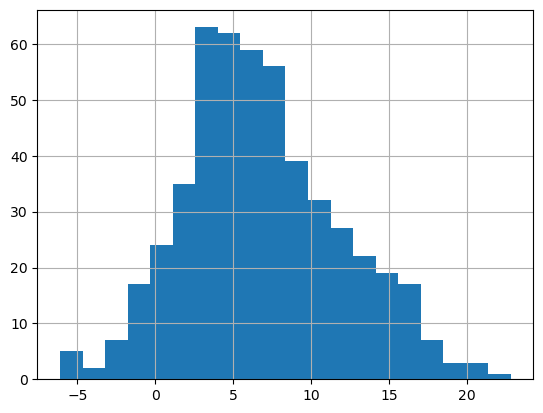

In [22]:
# Plot a histogram of the 'diff' column
sample_dem_data["diff"].hist(bins=20)

plt.show()

#### _Using ttest()_

Manually calculating test statistics and transforming them with a CDF to get a p-value is a lot of effort to  
compare two sample means. The comparison of two sample means is called a t-test, and the `pingouin` Python  
package has a `.ttest()` method to accomplish it. This method provides some flexibility in how you perform  
the test.

Explore the difference between the proportion of county-level votes for the Democratic candidate in 2012 and  
2016 to identify if the difference is significant. 

The hypotheses are as follows:

$H_{0}$: The proportion of democratic votes in 2012 and 2016 were the same.  
$H_{A}$: The proportion of democratic votes in 2012 and 2016 were different.

In [23]:
''' Conduct a t-test on the sample differences (the 'diff' column of 'sample_dem_data') using an  
appropriate alternative hypothesis. '''

test_results = pingouin.ttest(
    x=sample_dem_data["diff"],
    y=0,
    alternative="two-sided"
)

print(test_results)

                T  dof alternative          p-val         CI95%   cohen-d  \
T-test  30.298384  499   two-sided  3.600634e-115  [6.39, 7.27]  1.354985   

              BF10  power  
T-test  2.246e+111    1.0  


**Question**

What is the correct decision from the t-test assuming $\alpha$ = 0.01?

**Answer**

Reject the null hypothesis

In [24]:
''' Conduct a paired test on the democratic votes in 2012 and 2016  
using an appropriate alternative hypothesis. '''

paired_test_results = pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    paired=True,
    alternative="two-sided"
)

print(paired_test_results)

                T  dof alternative          p-val         CI95%   cohen-d  \
T-test  30.298384  499   two-sided  3.600634e-115  [6.39, 7.27]  0.454202   

              BF10  power  
T-test  2.246e+111    1.0  


**Question**

Compare the paired t-test to an (inappropriate) unpaired test on the same data.  
How does the p-value change?

In [25]:
pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided"
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,7.181565,998,two-sided,1.345737e-12,"[4.96, 8.7]",0.454202,4.308e+09,1.0


**Answer**

The p-value from the unpaired test is greated than the p-value from the paired test.

**Explanation**

When you have paired data, a paired t-test is preferable to the unpaired version  
because it reduces the chance of a false negative error.

### 2.4 ANOVA tests

#### _Visualizing many categories_

Before conducting tests on many categories, it's often helpful to perform exploratory data analysis (EDA),  
calculating summary statistics for each group and visualizing the distributions of the numeric variable for  
each category using box plots.

Here, we'll return to the late shipments data, and how the price of each package (pack_price) varies  
between the three shipment modes (shipment_mode): "Air", "Air Charter", and "Ocean".

In [26]:
''' Group 'late_shipments' by 'shipment_mode' and calculate the mean  
'pack_price' for each group. '''

xbar_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].mean()

print(xbar_pack_by_mode)

shipment_mode
Air            39.712395
Air Charter     4.226667
Ocean           6.432273
Name: pack_price, dtype: float64


In [27]:
''' Group 'late_shipments' by 'shipment_mode' and calculate the standard  
deviation 'pack_price' for each group. '''

s_pack_by_mode = late_shipments.groupby("shipment_mode")["pack_price"].std()

print(s_pack_by_mode)

shipment_mode
Air            48.932861
Air Charter     0.992969
Ocean           5.303047
Name: pack_price, dtype: float64


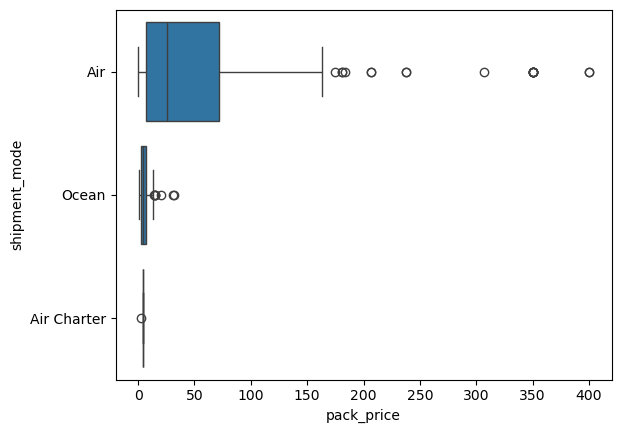

In [28]:
''' Create a boxplot from 'late_shipments' with 'pack_price' as 'x' and  
'shipment_mode' as 'y'. '''

sns.boxplot(
    x="pack_price",
    y="shipment_mode",
    data=late_shipments
)

plt.show()

#### _Conducting an ANOVA test_

The box plots made it look like the distribution of pack price was different for each of the three shipment  
modes. However, it didn't tell us whether the mean pack price was different in each category.  

To determine that, we can use an ANOVA test. The null and alternative hypotheses can be written as follows.

$H_{0}$: Pack prices for every category of shipment mode are the same.

$H_{A}$: Pack prices for some categories of shipment mode are different.

Use a significance level of 0.1.

In [29]:
''' Run an ANOVA on 'late_shipments' investigating 'pack_price' (the 
dependent variable) between the groups of 'shipment_mode'. '''

anova_results = pingouin.anova(
    data=late_shipments,
    dv="pack_price",
    between="shipment_mode"
)

print(anova_results)

          Source  ddof1  ddof2        F         p-unc       np2
0  shipment_mode      2    997  21.8646  5.089479e-10  0.042018


**Question** 

Assuming a significance level of 0.1, should you reject the null hypothesis that  
there is no difference in pack prices between shipment modes?

**Answer**

Yes. The p-value is less than or equal to the significance level, so the null   
hypothesis should be rejected.

**Explanation**

There is a significant difference in pack prices between the shipment  
modes. However, we don't know which shipment modes this applies to.

#### _Pairwise t-tests_

The ANOVA test didn't tell you which categories of shipment mode had significant differences in pack prices.  
To pinpoint which categories had differences, you could instead use pairwise t-tests.

In [30]:
''' Perform pairwise t-tests on late_shipments's 'pack_price' variable, grouped by 'shipment_mode',   
without doing any p-value adjustment. '''

pairwise_results = pingouin.pairwise_tests(
    data=late_shipments,
    dv="pack_price",
    between="shipment_mode"
)

print(pairwise_results)

        Contrast            A            B  Paired  Parametric          T  \
0  shipment_mode          Air  Air Charter   False        True  21.179625   
1  shipment_mode          Air        Ocean   False        True  19.335760   
2  shipment_mode  Air Charter        Ocean   False        True  -3.170654   

          dof alternative         p-unc       BF10    hedges  
0  600.685682   two-sided  8.748346e-75  5.809e+76  0.726592  
1  986.979785   two-sided  6.934555e-71  1.129e+67  0.711119  
2   35.615026   two-sided  3.123012e-03     15.277 -0.423775  


In [31]:
''' Perform the pairwise t-tests again using the Bonferroni p-value adjustment. '''

pairwise_bonf_results = pingouin.pairwise_tests(
    data=late_shipments,
    dv="pack_price",
    between="shipment_mode",
    padjust="bonf"
)

print(pairwise_bonf_results)

        Contrast            A            B  Paired  Parametric          T  \
0  shipment_mode          Air  Air Charter   False        True  21.179625   
1  shipment_mode          Air        Ocean   False        True  19.335760   
2  shipment_mode  Air Charter        Ocean   False        True  -3.170654   

          dof alternative         p-unc        p-corr p-adjust       BF10  \
0  600.685682   two-sided  8.748346e-75  2.624504e-74     bonf  5.809e+76   
1  986.979785   two-sided  6.934555e-71  2.080367e-70     bonf  1.129e+67   
2   35.615026   two-sided  3.123012e-03  9.369037e-03     bonf     15.277   

     hedges  
0  0.726592  
1  0.711119  
2 -0.423775  


**Question**

Using the Bonferroni correction results and assuming a significance level of 0.1, for which pairs of  
shipment modes should you reject the null hypothesis that the pack prices are equal?

**Answer**

"Ocean" and "Air Charter"; "Ocean" and "Air"; "Air Charter" and "Air"

**Explanation**

After applying the Bonferroni adjustment, the p-values for the   
t-tests between each of the three groups are all less than 0.1 .

## 3. Proportion Tests

**Proportion Tests** are statistical tests used to determine whether there is a significant difference in  
proportions between two or more groups. These tests compare the proportion of individuals with a particular  
characteristic in one group to that of another.

- **Two-Sample Proportion Test**: Compares proportions between two groups to see if they are significantly  
different.
  
- **Chi-Square Test of Independence**: Extends the proportion test to more than two groups, testing whether  
there is an association between two categorical variables across multiple groups.
  
- **Chi-Square Goodness of Fit Test**: Tests if the observed proportions in a sample match expected  
proportions for a single categorical variable.

These tests are used in various fields like medicine, marketing, and social sciences for categorical data  
analysis.

<small>_Source: OpenAI, ChatGPT_</small>

### 3.1 One-sample proportion tests

#### _t for proportions?_

**Question**

Do tests of proportion(s) use a $z$ or a $t$ test statistic and why?

**Answer**

$z$: The test statistic for proportion(s) has only one estimate  
of a parameter instead of two

#### _Test for single proportions_

In Chapter 1, you calculated a p-value for a test hypothesizing   
that the proportion of late shipments was greater than 6%.  

In that chapter, you used a bootstrap distribution to estimate  
the standard error of the statistic.  

An alternative is to use an equation for the standard error based  
on the sample proportion, hypothesized proportion, and sample size.

$$
z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0 * (1 - p_0)}{n}}}
$$

In [32]:
# Hypothsize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of shipments where late equals 'Yes' 
p_hat = (late_shipments["late"] == "Yes").mean()

# Calculate the number of observations in the sample
n = len(late_shipments)

print(p_hat, n)

0.061 1000


In [33]:
# Calculate the test statistic
numerator = p_hat - p_0

demominator = np.sqrt(p_0 * (1 - p_0) / n)

z_score = numerator / demominator

print(z_score)

0.13315591032282698


In [34]:
''' Calculate the p-value, remembering that this is a 'greater than' alternative 
hypothesis ''' 

p_value = 1 - norm.cdf(z_score)

print(p_value)

0.44703503936503364


**Note:** While bootstrapping can be used to estimate the standard error of any statistic,  
it is computationally intensive. For proportions, using a simple equation of the hypothesized  
proportion and sample size is easier to compute.

### 3.2 Two-sample proportion tests

#### _Test of two proportions_

Does the amount paid for freight affects whether or not the shipment was late? 

In the `late_shipments` dataset, whether or not the shipment was late is stored in the `late` column.   
Freight costs are stored in the `freight_cost_groups` column, and the categories are `"expensive"`  
and `"reasonable"`.

The hypotheses to test, with `"late"` corresponding to the proportion of late shipments for that group, are:

$H_{0}: late_{expensive} - late_{reasonable} = 0$

$H_{A}: late_{expensive} - late_{reasonable} > 0$

In [35]:
''' Calculate the estimates of population proportions (sample proportions) for 
each 'freight_cost_group. '''

p_hats = late_shipments.groupby("freight_cost_groups", as_index=False)["late"]\
    .value_counts(normalize=True)

print(p_hats)

  freight_cost_groups late  proportion
0           expensive   No    0.920904
1           expensive  Yes    0.079096
2          reasonable   No    0.964835
3          reasonable  Yes    0.035165


In [36]:
''' Calculate the sample sizes for the groups. '''

ns = late_shipments.groupby("freight_cost_groups", as_index=False)["late"].count()

print(ns)

  freight_cost_groups  late
0           expensive   531
1          reasonable   455


Calculate the pooled sample proportion, $\hat{p}$, from `p_hats` and `ns` using the equation:

$$
\hat{p} = \frac{n_{\text{expensive}} \times \hat{p}_{\text{expensive}} + n_{\text{reasonable}} \times \hat{p}_{\text{reasonable}}}{n_{\text{expensive}} + n_{\text{reasonable}}}
$$


In [37]:
# Assign values to variables used in the calculation
p_expensive = p_hats.iloc[1, 2]

p_reasonable = p_hats.iloc[3, 2]

n_expensive = ns.iloc[0, 1]

n_reasonable = ns.iloc[1, 1]

print(p_expensive, p_reasonable)
print(n_expensive, n_reasonable)

0.07909604519774012 0.035164835164835165
531 455


In [38]:
# Calculate the pooled sample proportion
p_hat = (n_expensive * p_expensive + n_reasonable * p_reasonable)\
    / (n_expensive + n_reasonable)

print(p_hat)

0.058823529411764705


Calculate the standard error of the sample using the equation:

$$
\text{SE}(\hat{p}_{\text{expensive}} - \hat{p}_{\text{reasonable}}) = \sqrt{\dfrac{\hat{p} \times (1 - \hat{p})}{n_{\text{expensive}}} + \dfrac{\hat{p} \times (1 - \hat{p})}{n_{\text{reasonable}}}}
$$

In [39]:
# Calculate p_hat multiplied by (1 - p_hat)
p_hat_times_not_p_hat = p_hat * (1 - p_hat)

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns = (
    p_hat_times_not_p_hat / n_expensive
    + p_hat_times_not_p_hat / n_reasonable
)

# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

print(std_error)


0.015031300895066685


Calculate the $z-score$ using the following equation:

$$
z = \frac{(\hat{p}_{\text{expensive}} - \hat{p}_{\text{reasonable}})}{\text{SE}(\hat{p}_{\text{expensive}} - \hat{p}_{\text{reasonable}})}
$$

In [40]:
# Calculate the z-score
z_score = (p_expensive - p_reasonable) / std_error

print(z_score)

2.922648567784529


In [41]:
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

print(p_value)

0.0017353400023595311


This small p-value leads us to suspect there is a larger proportion of late shipments for  
expensive freight compared to reasonable freight.

#### _proportions_ztest() for two samples_

Calculating the p-value manually takes a lot of effort, so while it's helpful to understand how the  
calculations work, it's not practical for real-world analyses. For everyday use, it's easier to rely  
on the `statsmodels` package.

In [42]:
# Import the statsmodels package
from statsmodels.stats.proportion import proportions_ztest

In [43]:
# Count the 'late' column values for each 'freight_cost_group' 
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")\
    ["late"].value_counts()

print(late_by_freight_cost_group)

freight_cost_groups  late
expensive            No      489
                     Yes      42
reasonable           No      439
                     Yes      16
Name: count, dtype: int64


In [44]:
# Create an array of the 'Yes' counts
positive_counts = np.array([42, 16])

''' Create an array of the total number of rows in
each 'freight_cost_group' ''' 
n = np.array([489+42, 439+16])

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(
    count=positive_counts,
    nobs=n,
    alternative="larger"
)

print(stat, p_value)

2.922648567784529 0.001735340002359578


The results are the same with less effort.

### 3.3 Chi-square test of independence

#### _How many tails for chi-square tests?_

Unlike `pingouin.ttest()` and `statsmodels.stats.proportion.proportions_ztest()`,  
`pingouin.chi2_independence()` does not have an `alternative` argument to specify  
which tails are considered by the alternative hypothesis.

Which tail is almost always considered in chi-square tests?

**Answer**

Right-tailed

**Explanation**

The chi-square test statistic is a square number, so it is always  
non-negative, so only the right tail tends to be of interest.

#### _Performing a chi-square test_

The _chi-square independence test_ compares proportions of successes of one categorical variable across the  
categories of another categorical variable.

Trade deals often use a form of business shorthand in order to specify the exact details of their contract.  
These are International Chamber of Commerce (ICC) international commercial terms, or incoterms for short.

The late_shipments dataset includes a vendor_inco_term that describes the incoterms that applied to a given  
shipment. The choices are:

* `EXW`: "Ex works". The buyer pays for transportation of the goods.  
* `CIP`: "Carriage and insurance paid to". The seller pays for freight  
and insurance until the goods board a ship.  
* `DDP`: "Delivered duty paid". The seller pays for transportation of   
the goods until they reach a destination port.    
* `FCA`: "Free carrier". The seller pays for transportation of the goods.  

Perhaps the incoterms affect whether or not the freight costs are expensive.  
Test these hypotheses with a significance level of 0.01.

$H_{0}$: vendor_inco_term and freight_cost_group are independent.

$H_{A}$: vendor_inco_term and freight_cost_group are associated.

In [45]:
''' Prepare the 'late_shipments' dataset by dropping the only row with  
the DDU incoterm. '''

# Find the index number of the row to drop
index_number = late_shipments[late_shipments["vendor_inco_term"] == "DDU"].index[0]
print(index_number)

764


In [46]:
# Drop the row with the DDU incoterm
late_shipments.drop(index_number, inplace=True)

In [47]:
''' Calculate the proportion of 'freight_cost_groups' in 'late_shipments' 
grouped by 'vendor_inco_term'. '''

props = late_shipments.groupby("vendor_inco_term")["freight_cost_groups"]\
    .value_counts(normalize=True)

print(props)

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: proportion, dtype: float64


In [48]:
# Convert props to a wide format
wide_props = props.unstack()

print(wide_props)

freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.320000    0.680000
DDP                   0.550000    0.450000
EXW                   0.583448    0.416552
FCA                   0.336364    0.663636


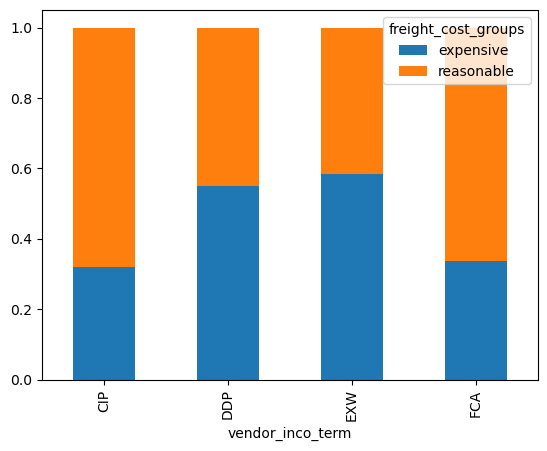

In [49]:
''' Create a proportional stacked bar plot with bars filled based on  
'freight_cost_groups' across the levels of 'vendor_inco_term'. '''

wide_props.plot(kind="bar", stacked=True)
plt.show()

In [50]:
''' Perform a chi-square test of independence on 'freight_cost_groups' 
and 'vendor_inco_term'. '''

expected, observed, stats = pingouin.chi2_independence(
    data=late_shipments,
    x="vendor_inco_term",
    y="freight_cost_groups"
)

print(stats[stats["test"] == "pearson"])

      test  lambda     chi2  dof          pval    cramer     power
0  pearson     1.0  33.6426  3.0  2.357026e-07  0.183511  0.999424


**Question**

What should you conclude from the hypothesis test?

**Answer**

Reject the null hypothesis and conclude that 'vendor_inco_term' and  
'freight_cost_groups' are associated.

### 3.4 Chi-square goodness of fit tests

#### _Visualizing goodness of fit_

The chi-square goodness of fit test compares proportions of each level of a categorical variable to  
hypothesized values. Before running such a test, it can be helpful to visually compare the distribution  
in the sample to the hypothesized distribution.

Recall the vendor incoterms in the late_shipments dataset. You hypothesize that the four values occur  
with these frequencies in the population of shipments.

* CIP: 0.05
* DDP: 0.1
* EXW: 0.75
* FCA: 0.1

In [51]:
# Create a DataFrame to store the frequencies
hypothesized = pd.DataFrame({
    "vendor_inco_term": ["CIP", "DDP", "EXW", "FCA"],
    "prop": [0.05, 0.10, 0.75, 0.10]
})

print(hypothesized)

  vendor_inco_term  prop
0              CIP  0.05
1              DDP  0.10
2              EXW  0.75
3              FCA  0.10


In [52]:
''' Create a DataFrame to store the 'value_counts()' of the 
'vendor_inco_term' column. ''' 

incoterm_counts = late_shipments["vendor_inco_term"].value_counts()

incoterm_counts = incoterm_counts.reset_index(name="n")\
    .sort_values("vendor_inco_term")

print(incoterm_counts)

  vendor_inco_term    n
3              CIP   56
2              DDP  100
0              EXW  732
1              FCA  111


In [53]:
# Find the total number of rows in 'late_shipments' 
n_total = len(late_shipments)

print(n_total)

999


In [54]:
''' Add a column named 'n' to the 'hypothesized' DataFrame that is the  
'hypothesized' 'prop' column times 'n_total'. '''

hypothesized["n"] = hypothesized["prop"] * n_total

print(hypothesized)

  vendor_inco_term  prop       n
0              CIP  0.05   49.95
1              DDP  0.10   99.90
2              EXW  0.75  749.25
3              FCA  0.10   99.90


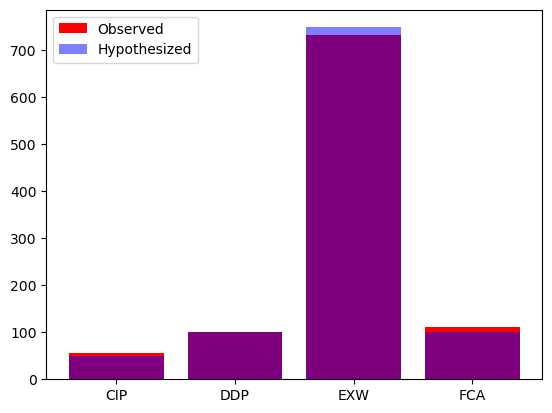

In [55]:
''' Plot a bar graph of 'n' vs. 'vendor_inco_term' for 'incoterm_counts'. '''

plt.bar(
    incoterm_counts["vendor_inco_term"], incoterm_counts["n"],
    color="red", label="Observed"
)

''' Add a bar plot for the 'hypothesized' counts. '''

plt.bar(
    hypothesized["vendor_inco_term"], hypothesized["n"],
    color="blue", alpha=0.5, label="Hypothesized"
)

plt.legend()
plt.show()

Two of the bars in the sample are very close to the hypothesized values while  
two are a little higher. The next exercise will test if these differences are  
statistically significant.

#### _Performing a goodness of fit test_

Perform a chi-square goodness of fit test to see whether the  
differences in the previous exercise are statistically significant.

Recall the hypotheses for this type of test:

$H_{0}$: The sample matches with the hypothesized distribution.

$H_{A}$: The sample does not match with the hypothesized distribution.

To decide which hypothesis to choose, set a significance level of 0.1.

In [56]:
''' Using the 'incoterm_counts' and 'hypothesized' datasets, perform a chi-square  
goodness of fit test on the incoterm counts, 'n'. '''

from scipy.stats import chisquare

gof_test = chisquare(
    f_obs=incoterm_counts["n"],
    f_exp=hypothesized["n"],
)

print(gof_test)

Power_divergenceResult(statistic=2.3633633633633613, pvalue=0.5004909543758689)


**Question**

What should you conclude from the hypothesis test?

**Answer**

Fail to reject the null hypothesis and conclude that `n` follows the  
distribution specified by `hypothesized`.

## 4. Non-Parametric Tests

Non-parametric tests are statistical methods used when the assumptions of parametric tests are not met.  
Parametric tests, like the t-test or ANOVA, assume that the data follows a normal distribution, has  
equal variances, and is measured on an interval or ratio scale.

Non-parametric tests, on the other hand, make fewer assumptions about the data. They are useful when:
* Data is not normally distributed
* Sample sizes are small
* Data is ordinal, ranked, or categorical

Examples of non-parametric tests include the Mann-Whitney U test (alternative to the t-test) and the  
Kruskal-Wallis test (alternative to ANOVA). These tests rely on the ranks of the data rather than the  
data's actual values, making them robust in situations where parametric assumptions don't hold.

<small>_Source: OpenAI, ChatGPT, September 22, 2024._</small>

### 4.1 Assumptions in hypothesis testing

#### _Common assumptions of hypothesis tests_

Hypothesis tests make assumptions about the dataset that they are testing, and the conclusions you draw  
from the test results are only valid if those assumptions hold. While some assumptions differ between  
types of test, others are common to all hypothesis tests.

**Question**

Which of the following statements is a common assumption of hypothesis tests?

**Answer**

Sample observations have no direct relationship with each other.

**Explanation**

All hypothesis tests assume that the data are collected at random from the population,  
that each row is independent of the others, and that the sample size is "big enough".

#### _Testing sample size_

In order to conduct a hypothesis test and be sure that the result is fair, a sample must meet three  
requirements: it is a random sample of the population, the observations are independent, and there are  
enough observations. Of these, only the last condition is easily testable with code.

The minimum sample size depends on the type of hypothesis tests you want to perform. Test some scenarios  
on the `late_shipments` dataset in the following exercises.

In [57]:
''' Get the count of each value in the 'freight_cost_groups' column of 'late_shipments'.
Insert a suitable number to inspect whether the counts are "big enough" for a two sample t-test. '''

counts = late_shipments["freight_cost_groups"].value_counts()

print(counts)

freight_cost_groups
expensive     531
reasonable    454
Name: count, dtype: int64


In [58]:
# Inspect whether the counts are big enough
print((counts >= 30).all())

True


In [59]:
''' Get the count of each value in the late column of late_shipments. Insert a suitable number  
to inspect whether the counts are "big enough" for a one sample proportion test.'''

counts = late_shipments["late"].value_counts()

print(counts)

late
No     938
Yes     61
Name: count, dtype: int64


In [60]:
# Inspect whether the counts are big enough
print((counts >= 10).all())

True


In [61]:
''' Get the count of each value in the 'freight_cost_groups' column of 'late_shipments' grouped by  
'vendor_inco_term'. Insert a suitable number to inspect whether the counts are "big enough" for a  
chi-square independence test. '''

counts = late_shipments.groupby("vendor_inco_term")["freight_cost_groups"]\
    .value_counts()

print(counts)

vendor_inco_term  freight_cost_groups
CIP               reasonable              34
                  expensive               16
DDP               expensive               55
                  reasonable              45
EXW               expensive              423
                  reasonable             302
FCA               reasonable              73
                  expensive               37
Name: count, dtype: int64


In [62]:
# Inspect whether the counts are big enough
print((counts >= 5).all())

True


In [63]:
''' Get the count of each value in the 'shipment_mode' column of 'late_shipments'.
Insert a suitable number to inspect whether the counts are "big enough" for an ANOVA test. '''

counts = late_shipments["shipment_mode"].value_counts()

print(counts)

shipment_mode
Air            905
Ocean           88
Air Charter      6
Name: count, dtype: int64


In [64]:
# Inspect whether the counts are big enough
print((counts >= 30).all())

False


While randomness and independence of observations can't easily be tested programmatically, you can test  
that your sample sizes are big enough to make a hypothesis test appropriate.  

Based on the last result, we should be a little cautious of the ANOVA test results given the small sample  
size for Air Charter.

### 4.2 Non-parametric tests

#### _Which parametric test?_

**Question**

Which test is a parametric equivalent to the Wilcoxon  
signed-rank test?

**Answer**

Paired t-test

**Explanation**

The Wilcoxon signed-rank test works well when  
the assumptions of a paired t-test aren't met.

#### _Wilcoxon signed-rank test_

Explore the difference between the proportion of county-level votes for the Democratic  
candidate in 2012 and 2016 to identify if the difference is significant.

In [67]:
''' Conduct a paired t-test on the percentage columns of 'sample_dem_data'  
using an appropriate alternative hypothesis. '''

paired_test_results = pingouin.ttest(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    paired=True,
    alternative="two-sided"
)

print(paired_test_results)

                T  dof alternative          p-val         CI95%   cohen-d  \
T-test  30.298384  499   two-sided  3.600634e-115  [6.39, 7.27]  0.454202   

              BF10  power  
T-test  2.246e+111    1.0  


In [68]:
''' Conduct a Wilcoxon signed-rank test on the same columns. '''

wilcoxon_test_results = pingouin.wilcoxon(
    x=sample_dem_data["dem_percent_12"],
    y=sample_dem_data["dem_percent_16"],
    alternative="two-sided"
)

print(wilcoxon_test_results)

           W-val alternative         p-val       RBC      CLES
Wilcoxon  2401.0   two-sided  1.780396e-77  0.961661  0.644816


Given the large sample size (500), similar results were obtained between the  
parametric t-test and non-parametric Wilcoxon test with a very small p-value.

### 4.3 Non-parametric ANOVA and unpaired t-tests

In [72]:
age_vs_comp = stack_overflow[["converted_comp", "age_first_code_cut"]]

age_vs_comp.head()

,converted_comp,age_first_code_cut
0,77556.0,adult
1,74970.0,child
2,594539.0,child
3,2000000.0,adult
4,37816.0,adult


In [71]:
age_vs_comp_wide = age_vs_comp.pivot(
    columns="age_first_code_cut",
    values="converted_comp"
)

age_vs_comp_wide.head()

age_first_code_cut,adult,child
0,77556.0,NaN
1,NaN,74970.0
2,NaN,594539.0
3,2000000.0,NaN
4,37816.0,NaN


In [73]:
pingouin.mwu(
    x=age_vs_comp_wide["child"],
    y=age_vs_comp_wide["adult"],
    alternative="greater"
)

,U-val,alternative,p-val,RBC,CLES
MWU,744365.5,greater,1.902723e-19,0.222516,0.611258


In [74]:
pingouin.kruskal(
    data=stack_overflow,
    dv="converted_comp",
    between="job_sat"
)

,Source,ddof1,H,p-unc
Kruskal,job_sat,4,72.814939,5.772915e-15


#### _Wilcoxon-Mann-Whitney_

Another class of non-parametric hypothesis tests are called rank sum tests. Ranks are the positions of  
numeric values from smallest to largest.

By calculating on the ranks of data instead of the actual values, you can avoid making assumptions about  
the distribution of the test statistic. It's more robust in the same way that a median is more robust  
than a mean.

One common rank-based test is the Wilcoxon-Mann-Whitney test, which is like a non-parametric t-test.

In [75]:
# Select 'weight_kilograms' and 'late' from 'late_shipments' 
weight_vs_late = late_shipments[["weight_kilograms", "late"]]

# Convert 'weight_vs_late' from long to wide format
weight_vs_late_wide = weight_vs_late.pivot(
    columns="late",
    values="weight_kilograms"
)

''' Run a Wilcoxon-Mann-Whitney test for a difference in 'weight_kilograms'  
when the shipment wa late and on-time. '''

wmw_test = pingouin.mwu(
    x=weight_vs_late_wide["Yes"],
    y=weight_vs_late_wide["No"],
    alternative="two-sided"
)

print(wmw_test)

       U-val alternative     p-val       RBC      CLES
MWU  38087.0   two-sided  0.000014  0.331294  0.665647


The small p-value here leads us to suspect that a difference does exist in the weight of the shipment  
and whether or not it was late.  

The Wilcoxon-Mann-Whitney test is useful when you cannot satisfy the assumptions for a parametric test  
comparing two means, like the t-test.

#### _Kruskal-Wallis_

The Kruskal-Wallis test is a non-parametric version of an ANOVA test,  
comparing the means across multiple groups.

In [77]:
''' Run a Kruskal-Wallis test on 'weight-kilograms' between the different 
shipment modes in 'late_shipments'. '''

kw_test = pingouin.kruskal(
    data=late_shipments,
    dv="weight_kilograms",
    between="vendor_inco_term"
)

print(kw_test)

                   Source  ddof1           H         p-unc
Kruskal  vendor_inco_term      3  143.067219  8.242568e-31


The Kruskal-Wallis test yielded a very small p-value, so there is evidence that at least one of the  
three groups of shipment mode has a different weight distribution than the others.  

The Kruskal-Wallis test is comparable to an ANOVA, which tests for a difference in means across  
multiple groups.

<div style="text-align: center; font-size: 18px; font-weight: bold; color: #F5DEB3;">
<span>[ End of notebook ]</span>
</div>